In [9]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import skimage
from skimage import measure, morphology, segmentation
from tqdm.notebook import tqdm
import scipy.ndimage as ndimage

# 檢查與驗證 dataset

In [10]:
!ls "/kaggle/input/luna16"

annotations.csv  evaluationScript      subset0	subset3
candidates.csv	 sampleSubmission.csv  subset1	subset4
candidates_V2	 seg-lungs-LUNA16      subset2



在檢查 dataset 時，發現有些在 annotations.csv 裡的 seriesuids 並沒有對應的 CT scans 資訊

在以下某位作者的作品中也有發現一樣的問題：
https://www.kaggle.com/code/mashruravi/pytorch-vs-cancer

Missing data¶

There are some seriesuids in the dataset that don't have corresponding CT scans in the dataset.

我會在開始訓練 U-net 模型前，做資料清洗

In [11]:
# annotations.csv 紀錄了由醫師標記的肺結節位置
import pandas as pd

annotations_df = pd.read_csv("/kaggle/input/luna16/annotations.csv")
print(annotations_df.head())

                                           seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150  


/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760173137525888934217.mhd
CT array shape: (280, 512, 512)
Mask array shape: (280, 512, 512)
Spacing: [0.83007812 0.83007812 1.        ]


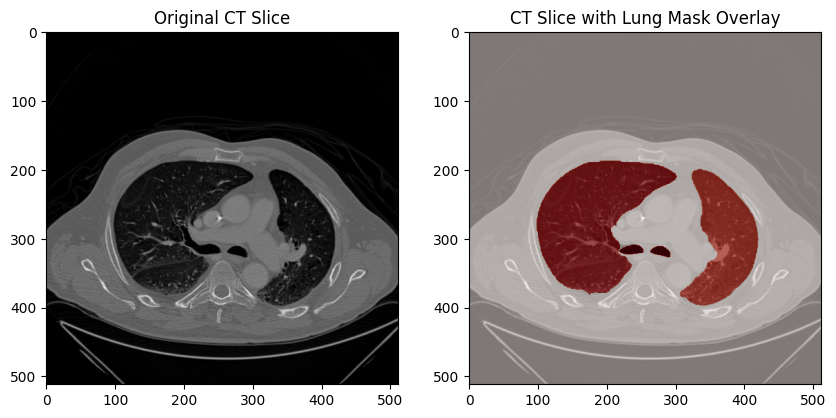

In [12]:
# 定義一個 load_ct_and_mask 的函數

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os # 導入 os 模組

def load_ct_and_mask(seriesuid, luna16_input_path="/kaggle/input/luna16"):
    """
    根據 seriesuid 載入 CT 影像和肺部分割 mask
    """
    ct_path = None
    for subset_index in range(5): # 依序檢查 subset0 到 subset4
        temp_ct_path = f"{luna16_input_path}/subset{subset_index}/subset{subset_index}/{seriesuid}.mhd"
        if os.path.exists(temp_ct_path): # 檢查檔案是否存在
            ct_path = temp_ct_path
            print(ct_path)
            break # 找到 CT 路徑就跳出迴圈
    if ct_path is None:
        raise FileNotFoundError(f"CT Image file not found for seriesuid: {seriesuid}") # 如果都沒找到，拋出錯誤

    mask_path = f"{luna16_input_path}/seg-lungs-LUNA16/seg-lungs-LUNA16/{seriesuid}.mhd" 
    
    ct_image = sitk.ReadImage(ct_path)
    mask_image = sitk.ReadImage(mask_path)

    ct_array = sitk.GetArrayFromImage(ct_image)
    mask_array = sitk.GetArrayFromImage(mask_image)
    spacing = np.array(ct_image.GetSpacing())

    return ct_array, mask_array, spacing, ct_path

# 驗證
sample_seriesuid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760173137525888934217" # 選擇一個 seriesuid 進行測試 

ct_array, mask_array, spacing, ct_path = load_ct_and_mask(sample_seriesuid)

print("CT array shape:", ct_array.shape)
print("Mask array shape:", mask_array.shape)
print("Spacing:", spacing)

slice_index = ct_array.shape[0] // 2 # 取中間切片

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(ct_array[slice_index], cmap='gray')
plt.title("Original CT Slice")

plt.subplot(1, 2, 2)
plt.imshow(ct_array[slice_index], cmap='gray') # 先顯示 CT slice
plt.imshow(mask_array[slice_index], cmap='Reds', alpha=0.5) # 疊加肺部 mask，紅色半透明
plt.title("CT Slice with Lung Mask Overlay")

plt.show()

In [ ]:
# # beta 加入 direction 與 origin
# import os
# import SimpleITK as sitk
# import numpy as np
# import pydicom # Import pydicom if you need to read DICOM metadata later

# def load_ct_and_mask(seriesuid, luna16_input_path="/kaggle/input/luna16"):
#     """
#     根據 seriesuid 載入 CT 影像和肺部分割 mask (修正 subset 路徑問題), 並返回元數據 (使用 SimpleITK.ReadImage for MHD).
#     """
#     ct_path = None
#     for subset_index in range(5): # 依序檢查 subset0 到 subset4
#         temp_ct_path = f"{luna16_input_path}/subset{subset_index}/subset{subset_index}/{seriesuid}.mhd"
#         if os.path.exists(temp_ct_path):
#             ct_path = temp_ct_path
#             print(ct_path) # 印出 CT 路徑
#             break # 找到 CT 路徑就跳出迴圈
#     if ct_path is None:
#         raise FileNotFoundError(f"CT Image file not found for seriesuid: {seriesuid}") # 如果都沒找到，拋出錯誤

#     mask_path = f"{luna16_input_path}/seg-lungs-LUNA16/seg-lungs-LUNA16/{seriesuid}.mhd"

#     # --- Use SimpleITK.ReadImage to read MHD file directly ---
#     ct_image = sitk.ReadImage(ct_path) # Read MHD directly
#     mask_image = sitk.ReadImage(mask_path) # Read mask MHD directly

#     ct_array = sitk.GetArrayFromImage(ct_image)
#     mask_array = sitk.GetArrayFromImage(mask_image)
#     spacing = np.array(ct_image.GetSpacing())
#     origin = np.array(ct_image.GetOrigin()) # Get origin metadata
#     direction = np.array(ct_image.GetDirection()).reshape(3, 3) # Get direction matrix metadata

#     return ct_array, mask_array, spacing, origin, direction, ct_path # Return spacing, origin, direction metadata

# # 選擇一個 seriesuid 進行測試 
# sample_seriesuid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259572521472765997306"

# ct_array, mask_array, spacing, ct_path = load_ct_and_mask(sample_seriesuid)

# print("CT array shape:", ct_array.shape)
# print("Mask array shape:", mask_array.shape)
# print("Spacing:", spacing)
# print("Origin", origin)
# print("direction", direction)


# slice_index = ct_array.shape[0] // 2 # 取中間切片

# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.imshow(ct_array[slice_index], cmap='gray')
# plt.title("Original CT Slice")

# plt.subplot(1, 2, 2)
# plt.imshow(ct_array[slice_index], cmap='gray') # 先顯示 CT slice
# plt.imshow(mask_array[slice_index], cmap='Reds', alpha=0.5) # 疊加肺部 mask，紅色半透明
# plt.title("CT Slice with Lung Mask Overlay")

# plt.show()

In [14]:
# 灰度值標準化 (Normalization)

def normalize_ct_image(ct_array):
    """
    將 CT 影像灰度值標準化到 [0, 1] 範圍 (debug 版本 2).
    """
    print(f"normalize_ct_image: Input ct_array dtype: {ct_array.dtype}") # 印出輸入資料類型
    print(f"normalize_ct_image: Input ct_array.min() = {ct_array.min()}, Input ct_array.max() = {ct_array.max()}") # 印出輸入灰度值範圍

    min_val = -1000  # HU 值下限
    max_val = 400    # HU 值上限

    print(f"normalize_ct_image: min_val = {min_val}, max_val = {max_val}")

    ct_array_clipped = np.clip(ct_array, min_val, max_val) # 裁剪灰度值範圍
    print(f"normalize_ct_image: ct_array_clipped.min() = {ct_array_clipped.min()}, ct_array_clipped.max() = {ct_array_clipped.max()}") # 印出裁剪後的灰度值範圍

    denominator = (max_val - min_val)
    print(f"normalize_ct_image: denominator (max_val - min_val) = {denominator}") # 印出分母

    if denominator == 0: # 檢查分母是否為 0，避免除以 0 錯誤
        ct_array_normalized = np.zeros_like(ct_array_clipped, dtype=np.float32) # 如果分母為 0，返回全 0 影像
    else:
        ct_array_normalized = (ct_array_clipped - min_val) / denominator # 線性縮放到 [0, 1]

    ct_array_normalized = ct_array_normalized.astype(np.float32) # 強制轉換資料類型為 float32！

    print(f"preprocess_ct_scan: Before return - ct_array_normalized.min() = {ct_array_normalized.min()}, ct_array_normalized.max() = {ct_array_normalized.max()}, dtype = {ct_array_normalized.dtype}") # 在 return 之前再次印出

    return ct_array_normalized

In [15]:
# 使用肺部分割 mask 提取 CT 影像的肺部 ROI

def extract_lung_roi(ct_array, mask_array):
    """
    使用肺部分割 mask 提取 CT 影像的肺部 ROI
    """
    roi_array = ct_array.copy() # 複製一份 ct_array，避免修改原始影像
    roi_array[mask_array == 0] = 0 # 將 mask 為 0 的區域 (肺部外區域) 像素值設為 0，肺部區域像素值保持不變
    return roi_array

In [16]:
# 將 normalize_ct_image 與 extract_lung_roi 整合到一個函數 preprocess_ct_scan 中，方便後續使用：

def preprocess_ct_scan(ct_array, mask_array):
    """
    對 CT 影像進行預處理：灰度值標準化和肺部 ROI 提取。

    Args:
        ct_array: CT 影像的 NumPy array (Z, Y, X)
        mask_array: 肺部分割 mask 的 NumPy array (Z, Y, X)，值為 0 或 1

    Returns:
        preprocessed_array: 預處理後的 CT 影像 NumPy array (Z, Y, X)，灰度值 [0, 1]，肺部外區域像素值為 0
    """
    normalized_array = normalize_ct_image(ct_array) # 灰度值標準化
    roi_array = extract_lung_roi(normalized_array, mask_array) # 肺部 ROI 提取
    return roi_array

/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275.mhd
normalize_ct_image: Input ct_array dtype: int16
normalize_ct_image: Input ct_array.min() = -2048, Input ct_array.max() = 3071
normalize_ct_image: min_val = -1000, max_val = 400
normalize_ct_image: ct_array_clipped.min() = -1000, ct_array_clipped.max() = 400
normalize_ct_image: denominator (max_val - min_val) = 1400
preprocess_ct_scan: Before return - ct_array_normalized.min() = 0.0, ct_array_normalized.max() = 1.0, dtype = float32


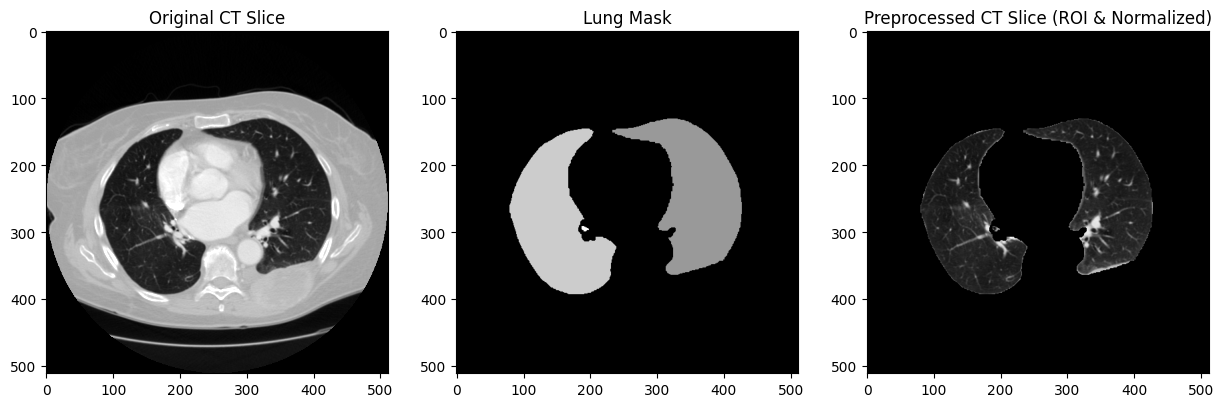

Preprocessed slice min value: 0.0000, max value: 1.0000


In [17]:
#驗證預處理效果

# 選擇一個 seriesuid 進行測試 
sample_seriesuid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275"

ct_array, mask_array, spacing, ct_path = load_ct_and_mask(sample_seriesuid)
preprocessed_array = preprocess_ct_scan(ct_array, mask_array)
preprocessed_slice = preprocessed_array[ct_array.shape[0] // 2] # 取預處理後的中間切片

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(ct_array[ct_array.shape[0] // 2], cmap='gray', vmin=-1000, vmax=400)
plt.title("Original CT Slice")

plt.subplot(1, 3, 2)
plt.imshow(mask_array[ct_array.shape[0] // 2], cmap='gray')
plt.title("Lung Mask")

plt.subplot(1, 3, 3)
plt.imshow(preprocessed_slice, cmap='gray', vmin=0, vmax=1)
plt.title("Preprocessed CT Slice (ROI & Normalized)")

plt.show()

print(f"Preprocessed slice min value: {preprocessed_slice.min():.4f}, max value: {preprocessed_slice.max():.4f}")


In [36]:
# 產生 CT scan 的結節分割 masks
def generate_nodule_masks(seriesuid, ct_array, annotations_df, luna16_input_path="/kaggle/input/luna16"):
    """
    產生 CT scan 的結節分割 masks
    """
    nodule_masks = np.zeros(ct_array.shape, dtype=np.uint8)
    print(f"Debug - generate_nodule_masks: 已初始化 nodule_masks，形狀: {nodule_masks.shape}, 資料類型: {nodule_masks.dtype}")
    
    scan_annotations = annotations_df[annotations_df['seriesuid'] == seriesuid]
    print(f"Debug - generate_nodule_masks: seriesuid {seriesuid} 的註解數量: {len(scan_annotations)}")
    
    # --- 獲取 CT 影像的 origin, spacing, direction ---
    ct_path = None
    for subset_index in range(5): # 依序檢查 subset0 到 subset4
        temp_ct_path = f"{luna16_input_path}/subset{subset_index}/subset{subset_index}/{seriesuid}.mhd"
        if os.path.exists(temp_ct_path):
            ct_path = temp_ct_path
            break
    
    if ct_path is None:
        raise FileNotFoundError(f"未找到 seriesuid: {seriesuid} 的 CT 影像檔案")
    
    # 使用 SimpleITK 讀取 mhd 檔案，獲取元資料
    mhd_file = sitk.ReadImage(ct_path) 
    origin_xyz = np.array(mhd_file.GetOrigin())      # 獲取原點座標 (X,Y,Z)
    spacing_xyz = np.array(mhd_file.GetSpacing())    # 獲取體素間距 (X,Y,Z)
    direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)  # 獲取方向矩陣
    
    # --- 元資料獲取完成 ---
    for _, annotation in scan_annotations.iterrows():
        # 獲取結節的世界座標 (X,Y,Z) 和直徑
        center_world = np.array([annotation.coordX, annotation.coordY, annotation.coordZ])
        diameter_mm = annotation.diameter_mm
        
        # --- 世界座標 (X,Y,Z) 到體素座標 (I,J,K) 的轉換 ---
        # 注意：SimpleITK 的座標系統是 (I,J,K) = (X,Y,Z)，但 NumPy 陣列的索引是 (K,J,I) = (Z,Y,X)
        # 1. 首先，計算從世界座標到連續體素座標的轉換 (考慮方向矩陣)
        center_voxel_ijk = np.linalg.solve(direction_matrix, (center_world - origin_xyz) / spacing_xyz)
        
        # 2. 將連續體素座標四捨五入到最近的整數索引，並將 (I,J,K) 轉換為 NumPy 的 (Z,Y,X) 順序
        center_zyx = np.round(center_voxel_ijk[::-1]).astype(int)  # 翻轉順序變成 (Z,Y,X)
        
        # 3. 計算結節半徑 (以像素為單位)
        # 使用 X 方向的間距來計算 (LUNA16 通常 X 和 Y 方向的間距相同)
        radius_pixel = int(round(diameter_mm / (2 * spacing_xyz[0])))
        
        print(f"Debug - 結節資訊: 世界座標 (X,Y,Z): {center_world}, 体素座標 (Z,Y,X): {center_zyx}, 直徑: {diameter_mm}mm, 半徑: {radius_pixel}px")
        
        # --- 在每個切片上繪製結節 ---
        # 確定結節可能出現的切片範圍 (Z方向)
        z_min = max(0, center_zyx[0] - radius_pixel)
        z_max = min(ct_array.shape[0] - 1, center_zyx[0] + radius_pixel)
        
        # 對範圍內的每個切片進行處理
        for z_index in range(z_min, z_max + 1):
            current_mask_slice = nodule_masks[z_index]
            
            # 調整當前切片上結節的半徑 (可選: 根據與中心切片的距離調整圓大小)
            distance_from_center = abs(z_index - center_zyx[0])
            if distance_from_center > radius_pixel:  # 超出半徑範圍則跳過
                continue
                
            # 可選: 根據到中心的距離調整圓半徑 (創建橢圓體效果)
            current_radius = radius_pixel  # 簡化版本: 所有切片使用相同半徑
            
            # 取出當前切片上的 YX 座標 (對應 skimage 的 row, col)
            center_yx = center_zyx[1:3]  # 獲取 (Y,X) 部分
            
            # 邊界檢查
            if (center_yx[0] < 0 or center_yx[0] >= current_mask_slice.shape[0] or
                center_yx[1] < 0 or center_yx[1] >= current_mask_slice.shape[1]):
                print(f"警告: 中心點 {center_yx} 超出切片邊界 {current_mask_slice.shape}")
                continue
                
            try:
                # 呼叫 skimage.draw.disk 繪製圓形 (使用 row, col 格式)
                rr, cc = skimage.draw.disk(center_yx, current_radius, shape=current_mask_slice.shape)
                current_mask_slice[rr, cc] = 1
                print(f"Debug - Drawing disk on slice {z_index}: center (Y,X): {center_yx}, radius: {current_radius}px, pixels set: {len(rr)}")
            except Exception as e:
                print(f"Error drawing disk on slice {z_index}: {e}")
                
    print(f"Debug - generate_nodule_masks: Final nodule_masks sum: {nodule_masks.sum()}")
    return nodule_masks

In [37]:
def calculate_nodule_center(nodule_annotation, ct_array, ct_path):
    """從標註信息計算結節在CT體積中的索引位置"""
    # 讀取CT元數據
    mhd_file = sitk.ReadImage(ct_path)
    origin_xyz = np.array(mhd_file.GetOrigin())
    spacing_xyz = np.array(mhd_file.GetSpacing())
    direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)
    
    # 獲取結節的世界坐標
    center_world = np.array([nodule_annotation.coordX, 
                             nodule_annotation.coordY, 
                             nodule_annotation.coordZ])
    
    # 轉換為體素坐標
    center_voxel_ijk = np.linalg.solve(direction_matrix, 
                                       (center_world - origin_xyz) / spacing_xyz)
    
    # 轉換為ZYX順序
    center_zyx = np.round(center_voxel_ijk[::-1]).astype(int)
    
    return center_zyx

def visualize_nodule_detection(seriesuid, ct_array, mask_array, nodule_masks, annotations_df, luna16_input_path="/kaggle/input/luna16"):
    """
    可視化肺結節檢測結果，包括原始CT、肺部分割和結節位置
    
    參數:
    seriesuid: CT掃描的ID
    ct_array: CT體積數據
    mask_array: 肺部分割掩碼
    nodule_masks: 生成的結節掩碼
    annotations_df: 包含標註信息的DataFrame
    luna16_input_path: LUNA16數據集路徑
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    import numpy as np
    
    # 1. 找出有結節的切片
    nodule_slices = np.where(nodule_masks.sum(axis=(1,2)) > 0)[0]
    
    if len(nodule_slices) == 0:
        print("警告：未檢測到任何結節！")
        # 選擇幾個默認切片
        num_slices = ct_array.shape[0]
        nodule_slices = [num_slices // 4, num_slices // 2, num_slices * 3 // 4]
    
    # 獲取這個CT掃描的所有結節標註
    scan_annotations = annotations_df[annotations_df['seriesuid'] == seriesuid]
    
    # 2. 對每個有結節的切片進行可視化
    for i, slice_idx in enumerate(nodule_slices):
        if i >= 3:  # 最多顯示3個切片
            break
            
        plt.figure(figsize=(18, 6))
        
        # 2.1 顯示原始CT切片
        plt.subplot(1, 4, 1)
        plt.imshow(ct_array[slice_idx], cmap='gray', vmin=-1000, vmax=400)
        plt.title(f"Original CT Slice #{slice_idx}")
        plt.axis('off')
        
        # 2.2 顯示肺部分割掩碼
        plt.subplot(1, 4, 2)
        plt.imshow(ct_array[slice_idx], cmap='gray', vmin=-1000, vmax=400)
        plt.imshow(mask_array[slice_idx], cmap='Blues', alpha=0.3)
        plt.title(f"Lung segmentation #{slice_idx}")
        plt.axis('off')
        
        # 2.3 顯示結節掩碼
        plt.subplot(1, 4, 3)
        plt.imshow(ct_array[slice_idx], cmap='gray', vmin=-1000, vmax=400)
        plt.imshow(nodule_masks[slice_idx], cmap='Reds', alpha=0.7)
        plt.title(f"Nodule Detection #{slice_idx}")
        plt.axis('off')
        
        # 2.4 結合顯示 (肺部 + 結節)
        plt.subplot(1, 4, 4)
        plt.imshow(ct_array[slice_idx], cmap='gray', vmin=-1000, vmax=400)
        plt.imshow(mask_array[slice_idx], cmap='Blues', alpha=0.3)
        plt.imshow(nodule_masks[slice_idx], cmap='Reds', alpha=0.7)
        plt.title(f"Overlay #{slice_idx}")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # 3. 3D可視化 - 中央切片的三視圖
    if len(scan_annotations) > 0:
        plt.figure(figsize=(18, 6))
        
        # 找出CT文件路徑
        ct_path = None
        for subset_index in range(5):
            temp_ct_path = f"{luna16_input_path}/subset{subset_index}/subset{subset_index}/{seriesuid}.mhd"
            if os.path.exists(temp_ct_path):
                ct_path = temp_ct_path
                break
        
        if ct_path is None:
            print("警告：找不到CT文件，無法顯示三視圖！")
            return
        
        # 取第一個結節作為中心
        nodule_annotation = scan_annotations.iloc[0]
        
        # 獲取該結節在CT體積中的索引位置
        center_z, center_y, center_x = calculate_nodule_center(nodule_annotation, ct_array, ct_path)
        
        # 確保索引在有效範圍內
        center_z = np.clip(center_z, 0, ct_array.shape[0]-1)
        center_y = np.clip(center_y, 0, ct_array.shape[1]-1)
        center_x = np.clip(center_x, 0, ct_array.shape[2]-1)
        
        # 顯示三個方向的切片
        plt.subplot(1, 3, 1)
        plt.imshow(ct_array[int(center_z)], cmap='gray', vmin=-1000, vmax=400)
        plt.imshow(nodule_masks[int(center_z)], cmap='Reds', alpha=0.7)
        plt.title(f"Z view (Z={int(center_z)})")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(ct_array[:, int(center_y), :].T, cmap='gray', vmin=-1000, vmax=400)
        plt.imshow(nodule_masks[:, int(center_y), :].T, cmap='Reds', alpha=0.7)
        plt.title(f"Y veiw (Y={int(center_y)})")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(ct_array[:, :, int(center_x)].T, cmap='gray', vmin=-1000, vmax=400)
        plt.imshow(nodule_masks[:, :, int(center_x)].T, cmap='Reds', alpha=0.7)
        plt.title(f"z veiw (X={int(center_x)})")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd
Debug - generate_nodule_masks: 已初始化 nodule_masks，形狀: (321, 512, 512), 資料類型: uint8
Debug - generate_nodule_masks: seriesuid 1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405 的註解數量: 4
Debug - 結節資訊: 世界座標 (X,Y,Z): [ -24.0138242  192.1024053 -391.0812764], 体素座標 (Z,Y,X): [266 328 173], 直徑: 8.143261683mm, 半徑: 7px
Debug - Drawing disk on slice 259: center (Y,X): [328 173], radius: 7px, pixels set: 145
Debug - Drawing disk on slice 260: center (Y,X): [328 173], radius: 7px, pixels set: 145
Debug - Drawing disk on slice 261: center (Y,X): [328 173], radius: 7px, pixels set: 145
Debug - Drawing disk on slice 262: center (Y,X): [328 173], radius: 7px, pixels set: 145
Debug - Drawing disk on slice 263: center (Y,X): [328 173], radius: 7px, pixels set: 145
Debug - Drawing disk on slice 264: center (Y,X): [328 173], radius: 7px, pixels set: 145
Debug - Drawing disk on slice 265: ce

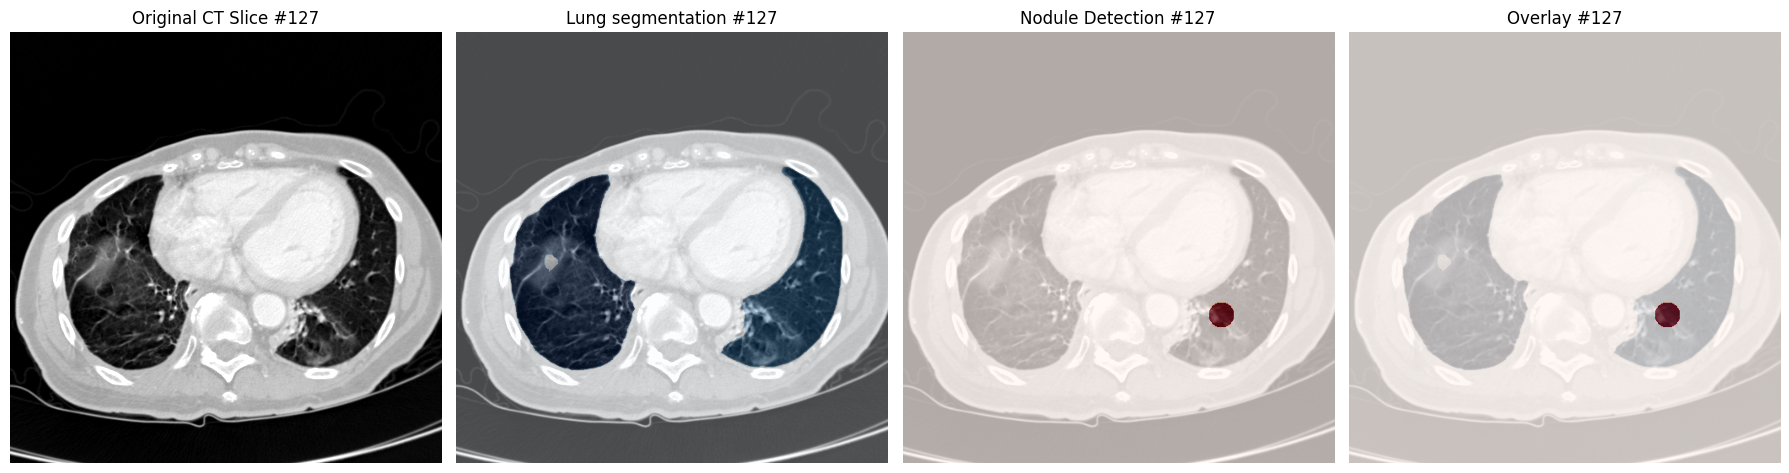

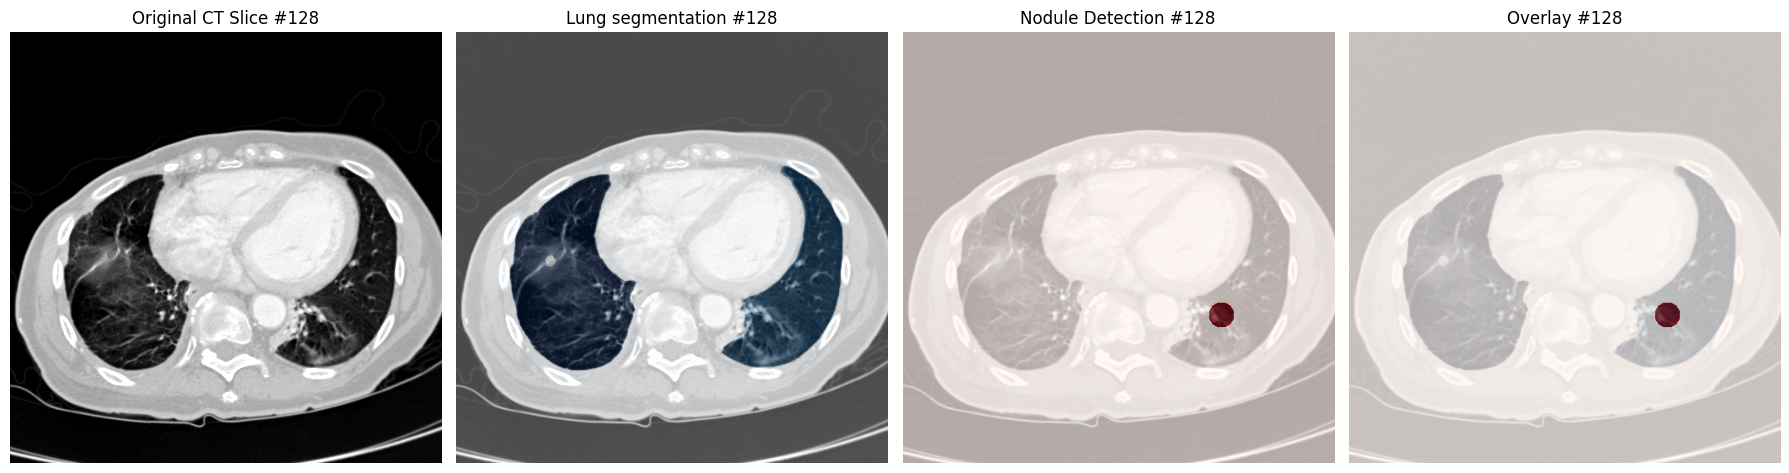

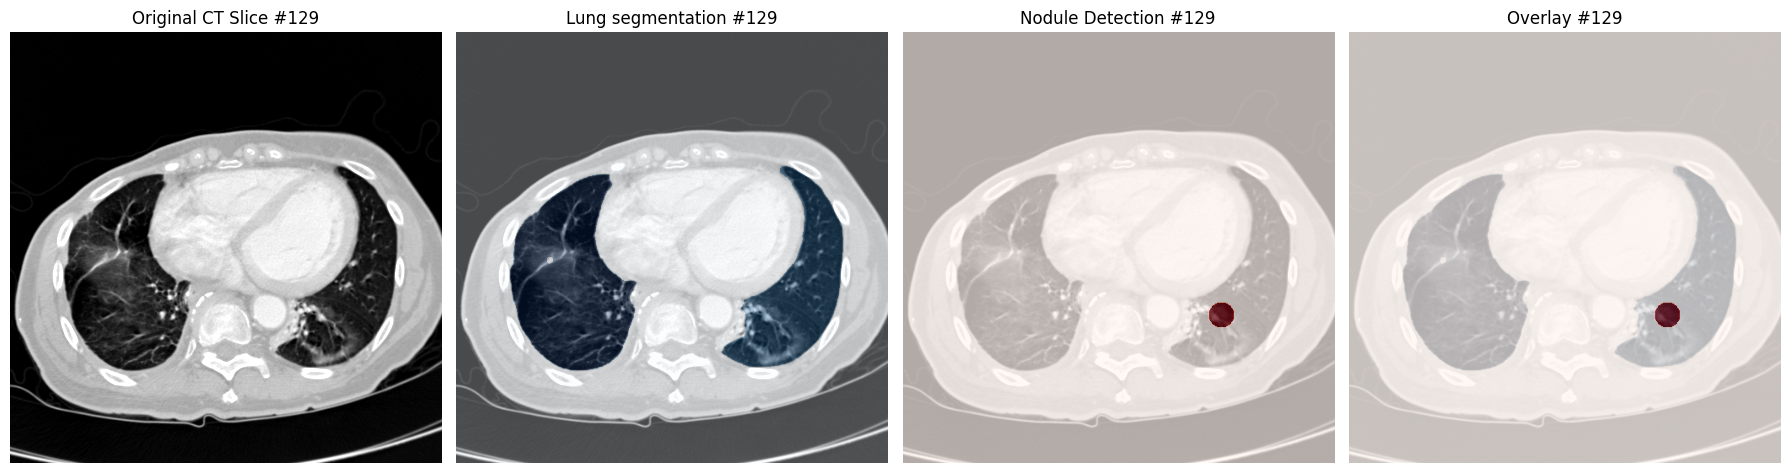

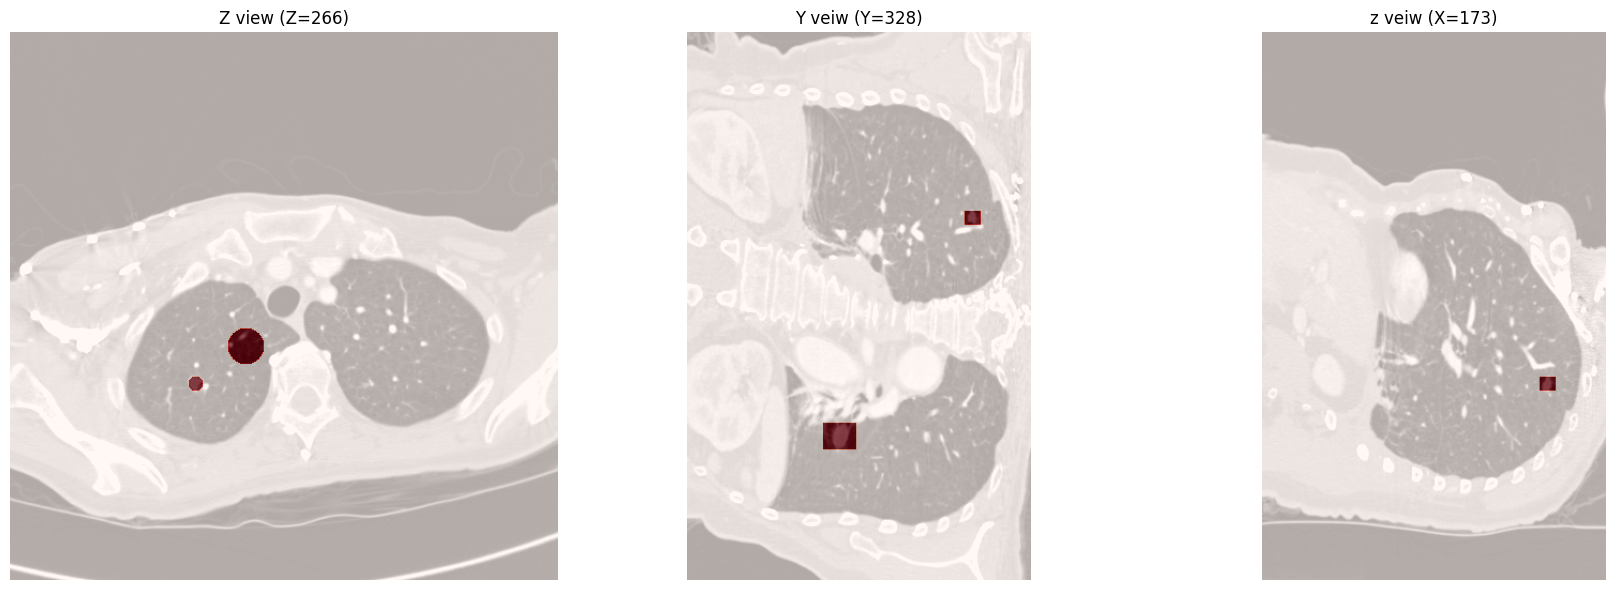

In [38]:
# 驗證結節

# 選取一個 seriesuid
test_seriesuid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405"
ct_array, mask_array, spacing, ct_path = load_ct_and_mask(test_seriesuid)
annotations_df = pd.read_csv("/kaggle/input/luna16/annotations.csv")

# 產生 nodule_masks
nodule_masks = generate_nodule_masks(test_seriesuid, ct_array, annotations_df)

# 可視話
visualize_nodule_detection(test_seriesuid, ct_array, mask_array, nodule_masks, annotations_df)

# 清洗 Dataset

In [14]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# --- 設定路徑 (請根據您的實際路徑修改) ---
LUNA16_ANNOTATIONS_PATH = '/kaggle/input/luna16/annotations.csv'
LUNA16_INPUT_PATH = '/kaggle/input/luna16'
OUTPUT_DATA_PATH = 'output_cleaned_dataset' # 輸出資料夾名稱
os.makedirs(OUTPUT_DATA_PATH, exist_ok=True) # 建立輸出資料夾，如果已存在則不報錯

# --- 載入 annotations.csv ---
annotations_df = pd.read_csv(LUNA16_ANNOTATIONS_PATH)
seriesuids = annotations_df['seriesuid'].unique()

# --- 劃分訓練集和驗證集 (與之前保持一致) ---
train_seriesuids, val_seriesuids = train_test_split(seriesuids, test_size=0.2, random_state=42)

def check_ct_file_exists(seriesuid, luna16_input_path):
    """檢查 seriesuid 對應的 CT 檔案是否存在"""
    for subset_index in range(5):
        ct_path = os.path.join(luna16_input_path, f'subset{subset_index}/subset{subset_index}/{seriesuid}.mhd')
        if os.path.exists(ct_path):
            return True # 找到檔案，返回 True
    return False # 遍歷所有 subset 都沒找到，返回 False

# --- 整理訓練集 SeriesUIDs ---
print("--- 整理訓練集 SeriesUIDs ---")
cleaned_train_seriesuids = []
excluded_train_seriesuids = []

for seriesuid in train_seriesuids:
    if check_ct_file_exists(seriesuid, LUNA16_INPUT_PATH):
        cleaned_train_seriesuids.append(seriesuid) # CT 檔案存在，加入 cleaned list
    else:
        print(f"警告: 訓練集 SeriesUID {seriesuid} CT 檔案遺失，已排除。") # 印出警告訊息
        excluded_train_seriesuids.append(seriesuid) # 加入 excluded list

print(f"原始訓練集 SeriesUID 數量: {len(train_seriesuids)}")
print(f"排除訓練集 SeriesUID 數量: {len(excluded_train_seriesuids)}")
print(f"清理後訓練集 SeriesUID 數量: {len(cleaned_train_seriesuids)}")

# --- 整理驗證集 SeriesUIDs (程式碼結構與訓練集相同) ---
print("\n--- 整理驗證集 SeriesUIDs ---")
cleaned_val_seriesuids = []
excluded_val_seriesuids = []

for seriesuid in val_seriesuids:
    if check_ct_file_exists(seriesuid, LUNA16_INPUT_PATH):
        cleaned_val_seriesuids.append(seriesuid) # CT 檔案存在，加入 cleaned list
    else:
        print(f"警告: 驗證集 SeriesUID {seriesuid} CT 檔案遺失，已排除。") # 印出警告訊息
        excluded_val_seriesuids.append(seriesuid) # 加入 excluded list

print(f"原始驗證集 SeriesUID 數量: {len(val_seriesuids)}")
print(f"排除驗證集 SeriesUID 數量: {len(excluded_val_seriesuids)}")
print(f"清理後驗證集 SeriesUID 數量: {len(cleaned_val_seriesuids)}")

# --- 儲存清理後的 SeriesUIDs 列表到 output 資料夾 ---
output_train_list_path = os.path.join(OUTPUT_DATA_PATH, 'cleaned_train_seriesuids.txt')
output_val_list_path = os.path.join(OUTPUT_DATA_PATH, 'cleaned_val_seriesuids.txt')

with open(output_train_list_path, 'w') as f:
    for seriesuid in cleaned_train_seriesuids:
        f.write(f"{seriesuid}\n") # 每行寫一個 seriesuid

with open(output_val_list_path, 'w') as f:
    for seriesuid in cleaned_val_seriesuids:
        f.write(f"{seriesuid}\n") # 每行寫一個 seriesuid

print(f"\n清理後的訓練集 SeriesUID 列表已儲存至: {output_train_list_path}")
print(f"清理後的驗證集 SeriesUID 列表已儲存至: {output_val_list_path}")
print("資料集清理程式碼執行完畢")

--- 整理訓練集 SeriesUIDs ---
警告: 訓練集 SeriesUID 1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872 CT 檔案遺失，已排除。
警告: 訓練集 SeriesUID 1.3.6.1.4.1.14519.5.2.1.6279.6001.292194861362266467652267941663 CT 檔案遺失，已排除。
警告: 訓練集 SeriesUID 1.3.6.1.4.1.14519.5.2.1.6279.6001.196251645377731223510086726530 CT 檔案遺失，已排除。
警告: 訓練集 SeriesUID 1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474 CT 檔案遺失，已排除。
警告: 訓練集 SeriesUID 1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826 CT 檔案遺失，已排除。
警告: 訓練集 SeriesUID 1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463 CT 檔案遺失，已排除。
警告: 訓練集 SeriesUID 1.3.6.1.4.1.14519.5.2.1.6279.6001.143622857676008763729469324839 CT 檔案遺失，已排除。
警告: 訓練集 SeriesUID 1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099 CT 檔案遺失，已排除。
警告: 訓練集 SeriesUID 1.3.6.1.4.1.14519.5.2.1.6279.6001.337005960787660957389988207064 CT 檔案遺失，已排除。
警告: 訓練集 SeriesUID 1.3.6.1.4.1.14519.5.2.1.6279.6001.140253591510022414496468423138 CT 檔案遺失，已排除。
警告: 訓練集 SeriesU

In [15]:
import pandas as pd
import numpy as np
import os
import SimpleITK as sitk
import skimage.draw

# --- 設定路徑 (請根據您的實際路徑修改) ---
LUNA16_ANNOTATIONS_PATH = '/kaggle/input/luna16/annotations.csv'
LUNA16_INPUT_PATH = '/kaggle/input/luna16'
OUTPUT_DATA_PATH = 'output_cleaned_dataset' # 假設您的清理程式碼輸出到這個資料夾

# --- 載入 annotations.csv ---
annotations_df = pd.read_csv(LUNA16_ANNOTATIONS_PATH)

# --- 載入清理後的 SeriesUIDs 列表 ---
cleaned_train_list_path = os.path.join(OUTPUT_DATA_PATH, 'cleaned_train_seriesuids.txt')
cleaned_val_list_path = os.path.join(OUTPUT_DATA_PATH, 'cleaned_val_seriesuids.txt')

def load_seriesuids_from_txt(filepath):
    """從文字檔案載入 SeriesUIDs 列表"""
    seriesuids = []
    with open(filepath, 'r') as f:
        for line in f:
            seriesuid = line.strip() # 移除行尾換行符號
            if seriesuid: # 確保不是空行
                seriesuids.append(seriesuid)
    return seriesuids

train_seriesuids = load_seriesuids_from_txt(cleaned_train_list_path) # 載入清理後的訓練集列表
val_seriesuids = load_seriesuids_from_txt(cleaned_val_list_path)     # 載入清理後的驗證集列表

print(f"已載入清理後的訓練集 SeriesUID 數量: {len(train_seriesuids)}")
print(f"已載入清理後的驗證集 SeriesUID 數量: {len(val_seriesuids)}")

已載入清理後的訓練集 SeriesUID 數量: 253
已載入清理後的驗證集 SeriesUID 數量: 58


建立 Data Generator

In [ ]:
print("--- 資料準備開始 (單一 SeriesUID 測試) ---")

test_seriesuid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760173137525888934217" # 選擇一個 seriesuid
print(f"測試 SeriesUID: {test_seriesuid}")

try:
    ct_array, mask_array, spacing, ct_path = load_ct_and_mask(test_seriesuid, LUNA16_INPUT_PATH)
    print(f"CT Array Shape: {ct_array.shape}, dtype: {ct_array.dtype}") # 檢查 CT shape 和 dtype
    print(f"Lung Mask Array Shape: {mask_array.shape}, dtype: {mask_array.dtype}") # 檢查肺部 mask shape 和 dtype

    preprocessed_ct_array = preprocess_ct_scan(ct_array, mask_array)
    print(f"Preprocessed CT Array Shape: {preprocessed_ct_array.shape}, dtype: {preprocessed_ct_array.dtype}, range: [{preprocessed_ct_array.min()}, {preprocessed_ct_array.max()}]") # 檢查預處理後 CT shape, dtype 和灰度值範圍

    nodule_masks_3d = generate_nodule_masks(test_seriesuid, ct_array, annotations_df, LUNA16_INPUT_PATH)
    print(f"Nodule Masks 3D Shape: {nodule_masks_3d.shape}, dtype: {nodule_masks_3d.dtype}, sum: {nodule_masks_3d.sum()}") # 檢查結節 mask shape, dtype 和總和

    scan_annotations = annotations_df[annotations_df['seriesuid'] == test_seriesuid]
    print(f"Number of Annotations for {test_seriesuid}: {len(scan_annotations)}") # 檢查註解數量

    if len(scan_annotations) > 0:
        for _, nodule_annotation in scan_annotations.iterrows():
            center_zyx = calculate_nodule_center(nodule_annotation, ct_array, ct_path)
            print(f"  Nodule Center ZYX: {center_zyx}") # 檢查結節中心坐標

            z_center = int(center_zyx[0])
            z_start = max(0, z_center - SLICE_RANGE // 2)
            z_end = min(ct_array.shape[0], z_center + SLICE_RANGE // 2 + 1)
            print(f"  Slice Range: z_start={z_start}, z_end={z_end}") # 檢查切片範圍

            for slice_index in range(z_start, z_end):
                input_slice = preprocessed_ct_array[slice_index]
                target_mask_slice = nodule_masks_3d[slice_index]

                if np.max(target_mask_slice) > 0:
                    input_images_train.append(np.expand_dims(input_slice, axis=-1))
                    target_masks_train.append(np.expand_dims(target_mask_slice, axis=-1))
                    print(f"    Slice {slice_index}: 加入訓練集") # 確認切片加入訓練集

    else:
        print(f"  SeriesUID: {test_seriesuid}, 沒有結節註解，跳過")

except Exception as e:
    print(f"處理 seriesuid {test_seriesuid} 時發生錯誤: {e}")

print("--- 單一 SeriesUID 測試完成 ---")

# (暫時省略轉換為 NumPy 陣列和印出形狀的程式碼，先驗證單一 SeriesUID 流程)

import matplotlib.pyplot as plt
# --- (步驟 2.1 的程式碼，保持不變) ---

print("--- 單一 SeriesUID 測試完成，開始可視化 ---")

# 選擇要可視化的切片索引 (例如，結節中心切片 z_center)
visualization_slice_index = z_center # 使用結節中心切片

# 顯示原始 CT, 肺部 mask, 預處理 CT, 結節 mask
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(ct_array[visualization_slice_index], cmap='gray')
plt.title(f'Original CT Slice {visualization_slice_index}')

plt.subplot(1, 4, 2)
plt.imshow(mask_array[visualization_slice_index], cmap='gray')
plt.title(f'Lung Mask Slice {visualization_slice_index}')

plt.subplot(1, 4, 3)
plt.imshow(preprocessed_ct_array[visualization_slice_index], cmap='gray')
plt.title(f'Preprocessed CT Slice {visualization_slice_index}')

plt.subplot(1, 4, 4)
plt.imshow(nodule_masks_3d[visualization_slice_index], cmap='gray') # 或 cmap='Reds' 等
plt.title(f'Nodule Mask Slice {visualization_slice_index}')

plt.tight_layout()
plt.show()

print("--- 可視化完成 ---")
print("資料準備程式碼 (單一 SeriesUID 測試) 執行完畢")

In [26]:
import numpy as np
import tensorflow as tf
import os
import pandas as pd # 假設需要 pandas 讀取 annotations.csv
import SimpleITK as sitk # 假設需要 SimpleITK 讀取影像

class LunaDataGenerator(tf.keras.utils.Sequence): # 繼承 tf.keras.utils.Sequence
    def __init__(self, seriesuids_list, annotations_df, luna16_input_path, batch_size=8, slice_range=3, augment=False):
        self.seriesuids_list = seriesuids_list
        self.annotations_df = annotations_df
        self.luna16_input_path = luna16_input_path
        self.batch_size = batch_size
        self.slice_range = slice_range
        self.augment = augment # 預留資料增強參數
        self.indexes = np.arange(len(self.seriesuids_list)) # 每個 epoch 開始時用於 shuffle 資料
        self.on_epoch_end() # 初始化 indexes

    def __len__(self): # 定義每個 epoch 的 batch 數量
        # 這裡需要根據您的資料生成邏輯來計算，例如，假設每個 seriesuid 生成大約 N 個樣本
        # return 大約的 batch 數量，例如 (len(self.seriesuids_list) * N) // self.batch_size
        # 更精確的方式是在 __getitem__ 中統計實際生成的樣本數，並在 __len__ 中返回
        return len(self.seriesuids_list) // self.batch_size # 先簡單估計，後續可以更精確計算

    def __getitem__(self, index):
        batch_seriesuids = self.seriesuids_list[index * self.batch_size:(index + 1) * self.batch_size]
        batch_input_images = []
        batch_target_masks = []

        for seriesuid in batch_seriesuids:
            try:
                # --- 載入 CT 和 mask ---
                ct_array, mask_array, spacing, ct_path = load_ct_and_mask(seriesuid, self.luna16_input_path) # 載入 CT 和 mask
                preprocessed_ct_array = preprocess_ct_scan(ct_array, mask_array) # 預處理 CT
                nodule_masks_3d = generate_nodule_masks(seriesuid, ct_array, self.annotations_df, self.luna16_input_path) # 生成結節 mask
                scan_annotations = self.annotations_df[self.annotations_df['seriesuid'] == seriesuid] # 取得註解

                if len(scan_annotations) > 0:
                    for _, nodule_annotation in scan_annotations.iterrows():
                        center_zyx = calculate_nodule_center(nodule_annotation, ct_array, ct_path) # 計算結節中心
                        z_center = int(center_zyx[0])
                        z_start = max(0, z_center - self.slice_range // 2)
                        z_end = min(ct_array.shape[0], z_center + self.slice_range // 2 + 1)

                        for slice_index in range(z_start, z_end):
                            input_slice = preprocessed_ct_array[slice_index]
                            target_mask_slice = nodule_masks_3d[slice_index]

                            if np.max(target_mask_slice) > 0: # 篩選包含結節的切片
                                input_images = np.expand_dims(input_slice, axis=-1) # 添加通道維度
                                target_masks = np.expand_dims(target_mask_slice, axis=-1) # 添加通道維度

                                # --- 資料增強 (如果 self.augment 為 True) ---
                                if self.augment:
                                    # 在這裡應用資料增強轉換 (例如使用 albumentations, imgaug 等)
                                    # augmented = augment_function(image=input_slice, mask=target_mask_slice)
                                    # input_images = augmented['image']
                                    # target_masks = augmented['mask']
                                    pass # 暫時省略資料增強程式碼

                                batch_input_images.append(input_images)
                                batch_target_masks.append(target_masks)
            except FileNotFoundError as e: # 捕捉 FileNotFoundError
                print(f"DataGenerator - 警告: CT 檔案遺失，跳過 seriesuid {seriesuid}: {e}") # 印出警告訊息
                continue # 跳過當前 seriesuid，繼續處理下一個 seriesuid
            except Exception as e:
                print(f"DataGenerator - 處理 seriesuid {seriesuid} 時發生錯誤: {e}")

        # 將 batch_input_images 和 batch_target_masks 轉換為 NumPy 陣列
        batch_input_images = np.array(batch_input_images)
        batch_target_masks = np.array(batch_target_masks)
        
        # --- Handle empty batch ---
        if len(batch_input_images) == 0: # Check if batch is empty
            print(f"DataGenerator - 警告: Batch {index} 為空 (所有 SeriesUIDs 檔案遺失). 返回 None.") # Print warning
            return None # Or raise ValueError("Empty batch") - returning None is simpler for now

        return batch_input_images, batch_target_masks # 返回一個 batch 的影像和 masks

    def on_epoch_end(self): # 在每個 epoch 結束時 shuffle 資料
        np.random.shuffle(self.indexes) # Shuffle indexes 

RecursionError: maximum recursion depth exceeded in comparison

# 驗證 data Generator

In [ ]:
# 使用少量 seriesuids 建立 Data Generator 實例 (測試用)
test_seriesuids = train_seriesuids[:10] # 例如取前 10 個 seriesuid
test_data_generator = LunaDataGenerator(test_seriesuids, annotations_df, LUNA16_INPUT_PATH, batch_size=2, slice_range=3, augment=False)

In [ ]:
import matplotlib.pyplot as plt

# --- (Data Generator 實例建立程式碼，例如 test_data_generator = LunaDataGenerator(...) ) ---

for i in range(5): # Iterate X batches 
    batch_data = test_data_generator[i] # Get batch data (can be None)

    if batch_data is not None: # Check if batch_data is not None (not an empty batch)
        batch_input_images, batch_target_masks = batch_data # Unpack batch data
        print(f"Batch {i+1} - Input Images Shape: {batch_input_images.shape}, dtype: {batch_input_images.dtype}, range: [{batch_input_images.min()}, {batch_input_images.max()}]")
        print(f"Batch {i+1} - Target Masks Shape: {batch_target_masks.shape}, dtype: {batch_target_masks.dtype}, unique values: {np.unique(batch_target_masks)}")

        # --- Visualization code (moved inside 'if batch_data is not None:') ---
        num_samples_to_visualize = min(len(batch_input_images), 2) # Visualize up to 2 samples per batch
        plt.figure(figsize=(10, 5 * num_samples_to_visualize))

        for j in range(num_samples_to_visualize):
            plt.subplot(num_samples_to_visualize, 2, 2*j+1)
            plt.imshow(batch_input_images[j][:, :, 0], cmap='gray') # Display input image
            plt.title(f'Batch {i+1}, Sample {j+1} - Input Image')
            plt.axis('off')

            plt.subplot(num_samples_to_visualize, 2, 2*j+2)
            plt.imshow(batch_target_masks[j][:, :, 0], cmap='gray') # Display target mask
            plt.title(f'Batch {i+1}, Sample {j+1} - Target Mask')
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        # --- End of visualization code ---

    else:
        print(f"Batch {i+1} is empty and skipped.") # Print message for empty batch

print("Data Generator Batch 可視化程式碼執行完畢")

# 建立模型

In [17]:
# --- 建立 Data Generator 實例 ---
BATCH_SIZE = 8 # 可調整
SLICE_RANGE = 3 # 可調整

train_data_generator = LunaDataGenerator(train_seriesuids, annotations_df, LUNA16_INPUT_PATH, batch_size=BATCH_SIZE, slice_range=SLICE_RANGE, augment=False)
val_data_generator = LunaDataGenerator(val_seriesuids, annotations_df, LUNA16_INPUT_PATH, batch_size=BATCH_SIZE, slice_range=SLICE_RANGE, augment=False)

In [4]:
import tensorflow
tensorflow.__version__

'2.15.0'

In [8]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
print("Segmentation Models version:", sm.__version__)

RecursionError: maximum recursion depth exceeded while calling a Python object